In [1]:
import os
import time

import mido
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [2]:
def getData(data_folder):
    """
    Walk through a folder, modifing each mid to fit in 128 ticks per beat and be only a piano channel
    :param data_folder: the base data folder used in the model, still nonrepresentative
    :return: it saves a midfile in piano format and other in paino+128tpb
    """
    counter = 0
    for dirpath, _, filenames in os.walk(data_folder):
        for File in filenames:
            path = os.path.join(dirpath, File)
            mid_copy = mido.MidiFile()

            try:
                mid = mido.MidiFile(path)
                tpb = mid.ticks_per_beat
                duration = int(mid.length)

                mid_copy.type = 1
                mid_copy.ticks_per_beat = tpb

                if 10 < duration < 600:
                    track = mido.merge_tracks(mid.tracks)

                    for msg in list(track):
                        if not msg.is_meta and msg.channel != 0 and msg.type == "note_on":
                            msg.velocity = 0

                mid_copy.tracks.append(track)
                mid_copy.save(f"OnlyPiano/{File}")

                mid_copy.ticks_per_beat = 128
                mid_copy.save(f"OnlyPiano_TPB128/{File}")

            except:
                print(path)
                continue

            counter += 1
            if counter % 250 == 0:
                print(counter)

In [3]:
start_time = time.time()
getData('TestDataset')
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.21500158309936523 seconds ---


In [4]:
def get_info(data_folder):
    counter = 0
    for dirpath, _, filenames in os.walk(data_folder):
        for File in filenames:
            path = os.path.join(dirpath, File)

            try:
                mid = mido.MidiFile(path)
                duration = mid.length
                track = mido.merge_tracks(mid.tracks)
                delta_time_ticks = 0

                for msg in list(track):
                    delta_time_ticks += msg.time


#                     if not msg.is_meta and msg.channel ==0:
#                         print(msg)
                beat_num = int(delta_time_ticks / 128)
                num_compasso = int(beat_num / 4)
                print(duration)
                print(delta_time_ticks)
                print(beat_num)
                print(num_compasso)
                print(int(num_compasso - 3))

            except:
                print(path)
                continue

            return mid

In [5]:
mid = get_info('OnlyPiano_TPB128')

63.285651000000584
14176
110
27
24


In [6]:
type(mid.tracks[0])

mido.midifiles.tracks.MidiTrack

In [8]:
TICKS_PER_BEAT = 32
BEAT_PER_COMPASS = 4
NUM_COMPASS = 4


def midi_to_pianoroll(mid):
    NUM_TICKS = TICKS_PER_BEAT * BEAT_PER_COMPASS * NUM_COMPASS

    track_num_ticks = mid.ticks_per_beat * BEAT_PER_COMPASS * NUM_COMPASS

    pianoroll = np.zeros((128, NUM_TICKS), dtype=np.uint8)
    state = np.zeros((128, 1), dtype=np.uint8)
    last_tick = 0
    current_tick = 0

    merged_track = mido.merge_tracks(mid.tracks)
    for msg in merged_track:
        new_tick = current_tick + msg.time
        if new_tick >= track_num_ticks:
            break
        current_tick = new_tick
        
        if msg.type not in ['note_on', 'note_off']:
            continue

        if current_tick != last_tick:
            pianoroll_last_tick = int(last_tick * TICKS_PER_BEAT /
                                      mid.ticks_per_beat)

            pianoroll_current_tick = int(current_tick * TICKS_PER_BEAT /
                                         mid.ticks_per_beat)

            pianoroll[:, pianoroll_last_tick:pianoroll_current_tick] = state

        last_tick = current_tick

        if msg.type == 'note_on' and msg.velocity > 0:
            state[msg.note] = msg.velocity
        elif msg.type == 'note_off':
            state[msg.note] = 0

    if current_tick < track_num_ticks:
        pianoroll_last_tick = int(last_tick * TICKS_PER_BEAT /
                                  mid.ticks_per_beat)
        pianoroll[:, pianoroll_last_tick:] = state

    return pianoroll


def pianoroll_to_midi(pianoroll):
    track = mido.MidiTrack()

    last_state = np.zeros(128, dtype=np.uint8)
    last_tick = 0
    for tick in range(0, pianoroll.shape[1]):
        current_state = pianoroll[:, tick]
        note_mismatches = current_state != last_state
        if not note_mismatches.any():
            continue
        changing_pos = np.where(note_mismatches)
        event_time = tick - last_tick
        last_tick = tick
        for note in changing_pos[0]:
            current_velocity = current_state[note]
            msg_type = 'note_off' if current_velocity == 0 else 'note_on'
            track.append(
                mido.Message(
                    msg_type,
                    note=note,
                    velocity=current_velocity,
                    time=16*event_time,
                ))

        last_state = current_state

    mid = mido.MidiFile()
    mid.tracks.append(track)
    return mid


pianoroll = midi_to_pianoroll(mid)
new_mid = pianoroll_to_midi(pianoroll)

new_mid.save('teste.mid')

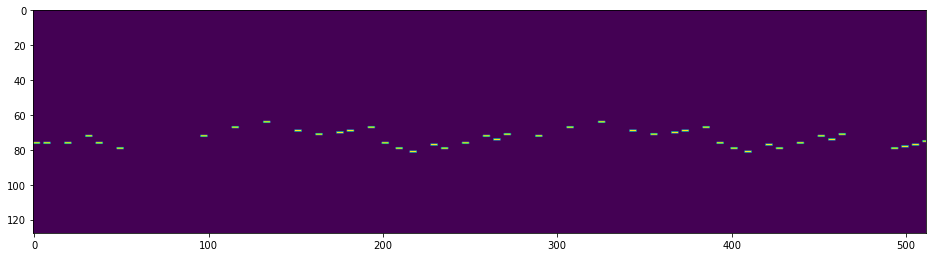

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 64))
plt.imshow(pianoroll)
plt.show()

In [ ]:
from mido import MidiFile, MidiTrack, Message
import numpy as np

num_notes = 128
samples_per_measure = 128


def midi_to_samples(mid):
    mid.ticks_per_beat = 128
    ticks_per_beat = mid.ticks_per_beat
    ticks_per_measure = 4 * ticks_per_beat

    all_notes = {}
    track = mido.merge_tracks(mid.tracks)

    abs_time = 0
    for msg in track:
        abs_time += msg.time

        if msg.type == 'note_on' and msg.velocity != 0:
            note = msg.note

            if note not in all_notes:
                all_notes[note] = []
            all_notes[note].append([abs_time])

        if msg.type == 'note_off' and len(all_notes[note][-1]) == 1:
            all_notes[note][-1].append(abs_time)

    samples = []
    for note in all_notes:
        for start, end in all_notes[note]:

            sample_ix = int(start / samples_per_measure)

            while len(samples) <= sample_ix:
                samples.append(
                    np.zeros((samples_per_measure, num_notes), dtype=np.uint8))

            sample = samples[sample_ix]
            start_ix = int(start - sample_ix * samples_per_measure)
            sample[start_ix, note] = 1

    return samples


def samples_to_midi(samples, fname):
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    mid.ticks_per_beat = 128

    abs_time = 0
    last_time = 0

    for sample in samples:
        for tick in range(sample.shape[0]):
            abs_time += 1

            for note in range(sample.shape[1]):
                if sample[tick, note] == 1 and (tick == 0 or
                                                sample[tick - 1, note] == 0):
                    delta_time = abs_time - last_time
                    track.append(
                        Message('note_on',
                                note=note,
                                velocity=127,
                                time=delta_time))
                    last_time = abs_time

                if sample[tick, note] == 1 and (tick == sample.shape[0] - 1 or
                                                sample[tick + 1, note] == 0):
                    track.append(
                        Message('note_off', note=note, velocity=127, time=0))

    mid.save(fname + ".mid")

In [ ]:
start_time = time.time()
s = midi_to_samples(mid)
a = samples_to_midi(s, "HackerPoet")
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
np.shape(s)

In [ ]:
# mid_parts = []
# for i in range(0,len(s),512):
#     mid_parts.append(s[i:i+512])

In [ ]:
# def midi_to_samples(mid):

#     TPM = mid.ticks_per_beat
#     all_notes = {}
#     track = mido.merge_tracks(mid.tracks)
#     abs_time = 0

#     for msg in track:
#         abs_time += msg.time

#         if msg.type == 'note_on' and msg.velocity != 0:
#             note = msg.note

#             if note not in all_notes:
#                 all_notes[note] = []
#             all_notes[note].append([abs_time])

#         if msg.type == 'note_off' and len(all_notes[note][-1]) == 1:
#             all_notes[note][-1].append(abs_time)

#     samples = [np.zeros((128, ), dtype=np.uint8) for i in range(abs_time)]

#     for note in all_notes:
#         for time in all_notes[note]:
#             for i in range(time[0], time[-1]):
#                 samples[i][note] = 1

#     return samples

# def samples_to_midi(samples, fname):
#     mid = mido.MidiFile()
#     track = mido.MidiTrack()
#     mid.tracks.append(track)

#     mid.ticks_per_beat = 128
#     samples = np.asarray(samples)

#     for tick in range(len(samples)):
#         for note in range(128):
#             if samples[tick,note] == 1 and (samples[tick - 1, note] == 0 or tick == 0):
#                 track.append(mido.Message('note_on', note = note, time = 0))
#                 end_note = np.where(samples[range(tick, len(samples)), note] == 0)[0][0]
#                 track.append(mido.Message('note_off', note = note, time = end_note))

#                 note_final_tick = tick + end_note

#                 track.append(mido.Message('note_on', note = 0, velocity = 0, time = 0))
#                 try:
#                     next_note = np.where(samples[note_final_tick: len(samples), : ] == 1)[0][0]
#                 except:
#                     next_note = 8
#                 track.append(mido.Message('note_off', note = 0, velocity = 0, time = next_note ))

#     mid.save(faname + ".mid")

In [ ]:
# start_time = time.time()
# s = midi_to_samples(mid)
# a = samples_to_midi(s, "eller")
# print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# np.shape(s)

In [ ]:
def split_mid(sample):
    splited = []
    for i in range(0, len(sample)):
        splited_sample = sample[i:i + 16]
        splited.append(splited_sample)
        samples_to_midi(splited_sample, f"Splited/{int(i/4)}")


#     return splited

In [ ]:
split_mid(s)